In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

def get_excluded_features():
    df = pd.read_csv('CodeBook-SELECT.csv')
    excluded = []

    for i in range(0, 377):
        desc = df.iloc[i]['Description']
        varname = df.iloc[i]['VarName']

        if 'ISCO' in desc or 'ISCO' in varname:
            excluded.append(varname)

        elif 'ISIC' in desc or 'ISIC' in varname:
            excluded.append(varname)

        elif 'mth' in desc or 'mth' in varname:
            excluded.append(varname)

        elif 'coded' in desc or 'coded' in varname:
            excluded.append(varname)

    return excluded

In [2]:
def get_included_numeric_columns(df):
    # Find numeric columns
    num_col = []
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            num_col.append(col)

    print('NUM COL')
    print(len(num_col))

    incl_num_cols = []
    for col in num_col:
        noise = [9996, 9997, 9998, 9999, 996, 997, 998, 999]
        df[col] = df[col].replace(noise, np.nan)
                
        if df[col].isna().sum() < 10000:
            m = df[col].mean()
            if m > 1990.0 and m < 2020.0:
                df[col] = df[col] - 1990.0
            incl_num_cols.append(col)
#             if m >= 1.0:
#                 if not (m > 9000.0 and m < 10000.0):
#                     incl_num_cols.append(col)

#                     if m > 1990.0 and m < 2020.0:
#                         df[col] = df[col] - 1990.0
                        
#     df[incl_num_cols] = df[incl_num_cols].fillna(df.median().iloc[0])
    df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].median().iloc[0])
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mean().iloc[0])
    print('ASU 1')
    print(df[incl_num_cols].isnull().values.any())
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mode())

    print('INCL COL')
    print(len(incl_num_cols))

    return df, incl_num_cols
# def get_included_numeric_columns(df):
#     # Find numeric columns
#     num_col = []
#     for col in df.columns:
#         if np.issubdtype(df[col].dtype, np.number):
#             num_col.append(col)

#     print('NUM COL')
#     print(len(num_col))

#     incl_num_cols = []
#     for col in num_col:
#         if not df[col].isna().sum() > 10000:
#             m = df[col].mean()
#             if m > 1990.0 and m < 2020.0:
#                 df[col] = df[col] - 1990.0
#             incl_num_cols.append(col)
# #             if m >= 1.0:
# #                 if not (m > 9000.0 and m < 10000.0):
# #                     incl_num_cols.append(col)

# #                     if m > 1990.0 and m < 2020.0:
# #                         df[col] = df[col] - 1990.0
                        
# #     df[incl_num_cols] = df[incl_num_cols].fillna(df.median().iloc[0])
#     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].median().iloc[0])
# #     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mean().iloc[0])
#     print('ASU 1')
#     print(df[incl_num_cols].isnull().values.any())
# #     df[incl_num_cols] = df[incl_num_cols].fillna(df[incl_num_cols].mode())

#     print('INCL COL')
#     print(len(incl_num_cols))

#     return df, incl_num_cols

In [3]:
def one_hot_encode(df, col_names):
    print(len(col_names))

    iter = 0
    new_cols = []
    for col in col_names:
        if( df[col].dtype == np.dtype('object')):
            if len(df[col].unique()) < 3:
                df[col] = df[col].astype('category')
                df[col] = df[col].cat.codes
                new_cols.append(col)
            else:
                dummies = pd.get_dummies(df[col],prefix=col)
                new_cols = new_cols + dummies.columns.tolist()
                df = pd.concat([df,dummies],axis=1)
                #drop the encoded column
                df.drop([col],axis = 1 , inplace=True)

            iter = iter + 1
            if (iter % 100 == 0):
                print(iter)

    return df, new_cols

In [4]:
def get_included_cat_cols(df, incl_num_cols):
    # TODO: Remove 999?

    cat_col = list(set(df.columns).difference(set(incl_num_cols)))

    print('CAT COL')
    print(len(cat_col))

    incl_cat_cols = []
    for col in cat_col:
        noise = ['9996', '9997', '9998', '9999', '996', '997', '998', '999']
        df[col] = df[col].replace(noise, np.nan)
        
#         incl_cat_cols.append(col)
        
        # INI PENTING BGT, KALO NGK JADI MINUS 900 MEANNYA WKWK
        if 'v' in col and col != 'vet' and len(col) < 5:
            if len(df[col].unique()) < 51:
                incl_cat_cols.append(col)
        else:
            incl_cat_cols.append(col)
#         incl_cat_cols.append(col)
    # for col in cat_col:
    #     if len(df[col].unique()) < 11:
    #             incl_cat_cols.append(col)
    #     incl_cat_cols.append(col)
    
#     df[incl_cat_cols] = df[incl_cat_cols].fillna(df.mode().iloc[0])
    df[incl_cat_cols] = df[incl_cat_cols].fillna(df[incl_cat_cols].mode().iloc[0])

    print('INCL COL')
    print(len(incl_num_cols))

    print('There were {} columns before encoding categorical features'.format(df.shape[1]))
    df, incl_cat_cols = one_hot_encode(df, incl_cat_cols)
    print('There are {} columns after encoding categorical features'.format(df.shape[1]))

    return df, incl_cat_cols

In [5]:
def prepare_train(df, incl_num_cols, incl_cat_cols):
    # Drop 30-40% of the males to obtain balance
    sampling_percentage = 0
#     sampling_percentage = 30
#     dropped_indexes = df[df['gender_r_Male'] == 1].sample(frac=float(sampling_percentage/100), random_state = 28).index
    dropped_indexes = df[df['gender_r'] == 1].sample(frac=float(sampling_percentage/100), random_state = 28).index

    with open('dropped_indexes_' + str(sampling_percentage) + '.pickle', 'wb') as outfile:
        # dump information to that file
        pickle.dump(dropped_indexes, outfile)

    train_df = df.drop(dropped_indexes)
    print(len(train_df))
    print(len(train_df.columns))
    train_df = train_df[incl_num_cols + incl_cat_cols]

    df = df[incl_num_cols + incl_cat_cols]
    print(len(df))
    print(len(df.columns))

    return df, train_df

In [6]:
from sklearn.model_selection import cross_val_score, cross_validate

def train_and_eval(df, train_df):
    X_train = train_df.drop(['job_performance'], axis=1).values
    y_train = train_df['job_performance'].values

    # from sklearn.model_selection import GridSearchCV
    # # Create the parameter grid based on the results of random search
    # param_grid = {
    #     'bootstrap': [True],
    #     'max_depth': [10, 20],
    #     'max_features': ['auto'],
    #     'min_samples_leaf': [50, 100],
    #     'min_samples_split': [100, 200],
    #     'n_estimators': [20, 50]
    # }
    # # Create a based model
    # rf = RandomForestRegressor(random_state = 40)
    # # Instantiate the grid search model
    # grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    # grid_search.fit(X_train, y_train)

    # print(grid_search.best_params_)
    # clf = grid_search.best_estimator_

    # Train the model using the training sets
#     clf = RandomForestRegressor(max_depth = 50, min_samples_leaf = 100, n_estimators = 100, random_state = 28)
    clf = RandomForestRegressor(max_depth = 20, min_samples_leaf = 25, min_samples_split = 50, n_estimators = 200, random_state = 28)
#     clf = RandomForestRegressor(max_depth = 25, min_samples_leaf = 25, n_estimators = 200, random_state = 28)
#     clf = linear_model.LinearRegression()
#     clf = linear_model.Lasso(alpha=0.1)
    # {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50}
#     print(clf.get_params())
#     clf = linear_model.LinearRegression()
#     scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
#     scores = cross_validate(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
#     print(scores)
    
    clf.fit(X_train, y_train)

    X_train = df.drop(['job_performance'], axis=1).values
    y_train = df['job_performance'].values

    y_pred = clf.predict(X_train)

    print('Mean: ' + str(np.mean(y_pred)))
    print('Variance: ' + str(np.var(y_pred)))

    return clf, y_pred, mean_squared_error(y_train, y_pred)

In [7]:
def main_1(model_name):
    df = pd.read_csv('hw4-trainingset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    df, train_df = prepare_train(df, incl_num_cols, incl_cat_cols)

    clf, df['y_pred'], mse = train_and_eval(df, train_df)

    print('MSE: ' + str(mse))

    with open(model_name, 'wb') as outfile:
        pickle.dump(clf, outfile)

    return df

In [8]:
# main_1('apa')

In [9]:
def main_2(model_name, train_cols):
    df = pd.read_csv('hw4-testset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    for missing_col in list(set(train_cols).difference(set(df.columns))):
        df[missing_col] = np.zeros(24500, dtype='int')

    df = df[train_cols]
    
#     for gajelas in ['v272', 'v52', 'v135']:
#         df[gajelas] = np.zeros(24500, dtype='int')

    X_test = df.drop(['job_performance'], axis=1).values
    print(np.where(np.isnan(X_test)))
    
    for idx in set(np.where(np.isnan(X_test))[1]):
        X_test[:, idx] = np.zeros(24500, dtype='int')

    with open(model_name, 'rb') as infile:
        clf = pickle.load(infile)

    df['job_performance'] = clf.predict(X_test)

    print('Mean: ' + str(np.mean(df['job_performance'])))
    print('Variance: ' + str(np.var(df['job_performance'])))

    return df, X_test

In [10]:
# main_2('test_model.pickle', [])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60
ASU 1
False
INCL COL
24
CAT COL
319
INCL COL
24
There were 343 columns before encoding categorical features
311
100
200
There are 1332 columns after encoding categorical features
20000
1332
20000
1295
Mean: 2909.6585986779833
Variance: 91647.05802952456
MSE: 42679.36504122989


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b3fc390>]],
      dtype=object)

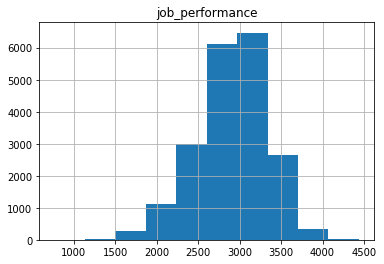

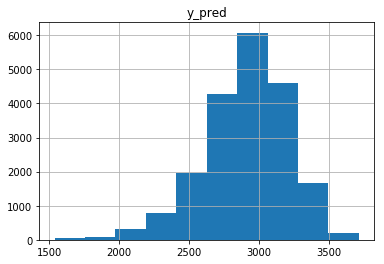

In [11]:
x = main_1('test_model.pickle')
# print('NUMS')
#     print(set(x).difference(set(a)))
# print('----')
# print(set(a).difference(set(x)))
# print('----')
#
# print('CATS')
# print(set(y).difference(set(b)))
# print('----')
# print(set(b).difference(set(y)))
# print('----')

%matplotlib inline
x.hist(column='job_performance')
x.hist(column='y_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5b4be0>]],
      dtype=object)

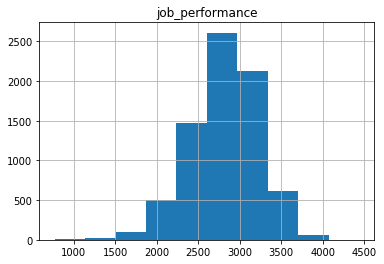

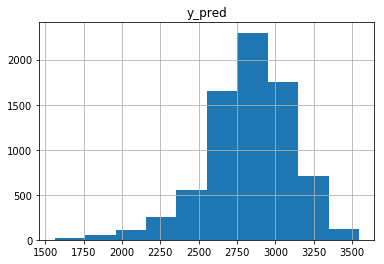

In [12]:
x[x['gender_r'] == 0].hist(column='job_performance')
x[x['gender_r'] == 0].hist(column='y_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b587b38>]],
      dtype=object)

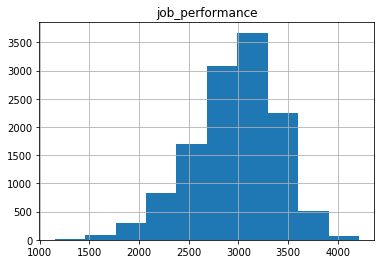

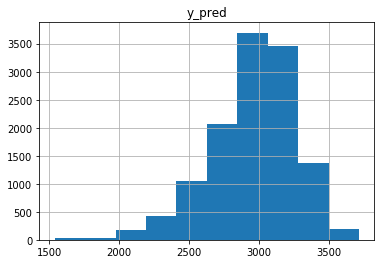

In [13]:
x[x['gender_r'] == 1].hist(column='job_performance')
x[x['gender_r'] == 1].hist(column='y_pred')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60
ASU 1
False
INCL COL
15
CAT COL
328
INCL COL
15
There were 343 columns before encoding categorical features
311
100
200
There are 1353 columns after encoding categorical features
(array([    1,     2,     3, ..., 24497, 24498, 24498]), array([22, 19, 19, ..., 22, 19, 22]))
Mean: 2714.9780419965273
Variance: 53666.623275151134


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ae4a1d0>]],
      dtype=object)

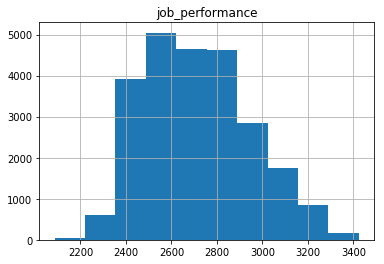

In [14]:
%matplotlib inline
a_df, a_x_test = main_2('test_model.pickle', x.drop(['y_pred'], axis=1).columns)
a_df.hist('job_performance')

In [15]:
# print(a_df.columns[[19,20,22]])
# a_x_test[:, 22]
# print(np.count_nonzero(~np.isnan(a_x_test[:, 19])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 20])))
# print(np.count_nonzero(~np.isnan(a_x_test[:, 2])))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b48fa58>]],
      dtype=object)

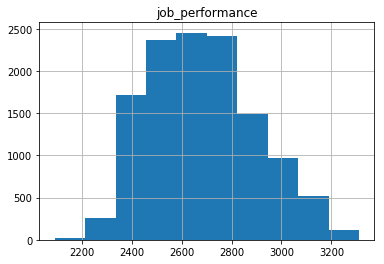

In [16]:
a_df[a_df['gender_r'] == 0].hist(column='job_performance')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b3d8c88>]],
      dtype=object)

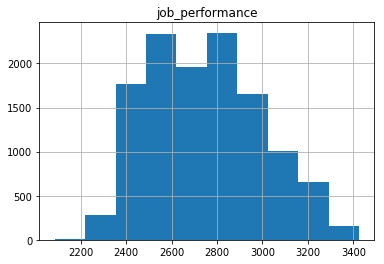

In [17]:
a_df[a_df['gender_r'] == 1].hist(column='job_performance')

In [18]:
# TODO: MEDIAN and SCALER
# kalo bisa regression bgs
# Insight: LASSO BETTER MEDIAN
# MEDIAN MEAN NGK NGARUH

# min_sample leaf 50, max_depth 20 estimators 200 dapetnya 75k

In [19]:
len(a_df[a_df['job_performance'] <= 3200]) / 24500

0.9728571428571429

In [20]:
len(x[x['job_performance'] <= 2200]) / 20000

0.0637

In [21]:
len(x[x['y_pred'] <= 3200]) / 20000

0.8405

In [22]:
df = pd.read_csv('hw4-trainingset-gd2551.csv')
df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
print('Mean train: ' + str(df['job_performance'].mean()))
print('Median train: ' + str(df['job_performance'].median()))
print('Mean male: ' + str(df[df['gender_r'] == 'Male']['job_performance'].mean()))
print('Median male: ' + str(df[df['gender_r'] == 'Male']['job_performance'].median()))
print('Mean female: ' + str(df[df['gender_r'] == 'Female']['job_performance'].mean()))
print('Median female: ' + str(df[df['gender_r'] == 'Female']['job_performance'].median()))

Mean train: 2909.9065328638526
Median train: 2942.4136951062956
Mean male: 2966.0717037520453
Median male: 3012.53908781253
Mean female: 2816.3976973877757
Median female: 2841.2000023565197


In [24]:
print('Mean train: ' + str(x['y_pred'].mean()))
print('Median train: ' + str(x['y_pred'].median()))
print('Mean male: ' + str(x[x['gender_r'] == 0]['y_pred'].mean()))
print('Median male: ' + str(x[x['gender_r'] == 0]['y_pred'].median()))
print('Mean female: ' + str(x[x['gender_r'] == 1]['y_pred'].mean()))
print('Median female: ' + str(x[x['gender_r'] == 1]['y_pred'].median()))

Mean train: 2909.6585986779833
Median train: 2933.6678206581723
Mean male: 2829.1129883191193
Median male: 2849.131328901663
Mean female: 2958.037534711858
Median female: 2995.5398162228166


In [25]:
print('Mean train: ' + str(a_df['job_performance'].mean()))
print('Median train: ' + str(a_df['job_performance'].median()))
print('Mean male: ' + str(a_df[a_df['gender_r'] == 0]['job_performance'].mean()))
print('Median male: ' + str(a_df[a_df['gender_r'] == 0]['job_performance'].median()))
print('Mean female: ' + str(a_df[a_df['gender_r'] == 1]['job_performance'].mean()))
print('Median female: ' + str(a_df[a_df['gender_r'] == 1]['job_performance'].median()))

Mean train: 2714.9780419965273
Median train: 2698.6097839483737
Mean male: 2683.588568908664
Median male: 2668.381180602935
Mean female: 2746.806167811471
Median female: 2738.2044080244414


In [27]:
# Submission
final_df = pd.read_csv('hw4-testset-gd2551.csv')
final_df['job_performance'] = a_df['job_performance']
final_df.to_csv(index=False, path_or_buf='rf_43k_mse.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (50,172,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
as_df = pd.read_csv('rf_43k_mse.csv')

In [29]:
len(as_df)

24500

In [30]:
as_df['job_performance']

0        2616.901510
1        2841.516534
2        2330.758008
3        2508.887245
4        2599.188401
            ...     
24495    2952.076646
24496    2953.676822
24497    2655.430018
24498    2497.847718
24499    2847.372762
Name: job_performance, Length: 24500, dtype: float64